# All imports #

In [1]:
from __future__ import print_function

import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn
import keras
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input

from keras_uncertainty.models import MCDropoutClassifier, MCDropoutRegressor
from keras_uncertainty.utils import numpy_regression_nll
from keras_uncertainty.models import DeepEnsembleRegressor, deep_ensemble_regression_nll_loss



/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/d

In [2]:
def load_joint_space_csv_chunks(file_path):
    data_frame = pd.read_csv(file_path, skiprows=1, header=None)
    del data_frame[18]
    return data_frame

def load_task_space_csv_chunks(file_path):
    return pd.read_csv(file_path, skiprows=1, header=None)


In [3]:
##please select the appropriate folder, willl use os.path.join() for completed script
TRAIN_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/'
TEST_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/test_4steps'

X_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_sysstate_q.csv')
x_train = load_task_space_csv_chunks(X_TRAIN_FILE)
q_train = load_joint_space_csv_chunks(Q_TRAIN_FILE)

X_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_sysstate_q.csv')
x_test = load_task_space_csv_chunks(X_TEST_FILE)
q_test = load_joint_space_csv_chunks(Q_TEST_FILE)

# Splitting the dataset with SD #

In [4]:

x_train_df = pd.DataFrame(x_train)
q_train_df = pd.DataFrame(q_train)
x_test_df = pd.DataFrame(x_test)
q_test_df = pd.DataFrame(q_test)


from sklearn.ensemble import IsolationForest


clf = IsolationForest(n_estimators=100, max_samples='auto', max_features=1, bootstrap=False, n_jobs= -1, random_state=42, verbose=0)
clf.fit(q_train_df)

pred = clf.predict(q_train_df)
q_train_df['anamoly'] = pred
print(q_train_df['anamoly'].value_counts())

InDistribution_Q_Train = q_train_df[q_train_df['anamoly'] == 1]
OutDistribution_Q_Train =   q_train_df[q_train_df['anamoly'] == -1]
InDistribution_X_Train =    x_train_df[q_train_df['anamoly'] == 1]
OutDistribution_X_Train =   x_train_df[q_train_df['anamoly'] == -1]

clf_test = IsolationForest(n_estimators=100, max_samples='auto', max_features=1, bootstrap=False, n_jobs= -1, random_state=42, verbose=0)
clf_test.fit(q_test_df)
pred_test = clf.predict(q_test_df)
q_test_df['anamoly'] = pred_test

InDistribution_Q_Test = q_test_df[q_test_df['anamoly'] == 1]
OutDistribution_Q_Test =q_test_df[q_test_df['anamoly'] == -1]
InDistribution_X_Test = x_test_df[q_test_df['anamoly'] == 1]
OutDistribution_X_Test =x_test_df[q_test_df['anamoly'] == -1]

x_train_1 = InDistribution_X_Train
q_train_1 = InDistribution_Q_Train.drop(['anamoly'], axis=1)
x_test_1 = InDistribution_X_Test
q_test_1 = InDistribution_Q_Test.drop(['anamoly'], axis=1)

OOD_x_train = OutDistribution_X_Train
OOD_q_train = OutDistribution_Q_Train.drop(['anamoly'], axis=1)
OOD_x_test = OutDistribution_X_Test
OOD_q_test = OutDistribution_Q_Test.drop(['anamoly'], axis=1)




print("//////////////////////")
print(x_train_1.shape, OOD_x_train.shape, x_test_1.shape, OOD_x_test.shape)


/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


 1    14062
-1     1563
Name: anamoly, dtype: int64


/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


//////////////////////
(14062, 9) (1563, 9) (3790, 9) (306, 9)


/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [5]:

x_scaler = MinMaxScaler()
q_scaler = MinMaxScaler()

#In order training set
x_train_1 = x_scaler.fit_transform(x_train_1)
q_train_1 = q_scaler.fit_transform(q_train_1)
q_test = q_test.drop(['anamoly'], axis=1)

#complete test set
x_test = x_scaler.transform(x_test)
q_test = q_scaler.transform(q_test)

#split testing data
IOD_x_test = x_scaler.transform(x_test_1)
IOD_q_test = q_scaler.transform(q_test_1)

OOD_x_test = x_scaler.transform(OOD_x_test)
OOD_q_test = q_scaler.transform(OOD_q_test)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4096 samples in 0.003s...
[t-SNE] Computed neighbors for 4096 samples in 0.255s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4096
[t-SNE] Computed conditional probabilities for sample 2000 / 4096
[t-SNE] Computed conditional probabilities for sample 3000 / 4096
[t-SNE] Computed conditional probabilities for sample 4000 / 4096
[t-SNE] Computed conditional probabilities for sample 4096 / 4096
[t-SNE] Mean sigma: 0.390412
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.351875
[t-SNE] KL divergence after 300 iterations: 1.690229


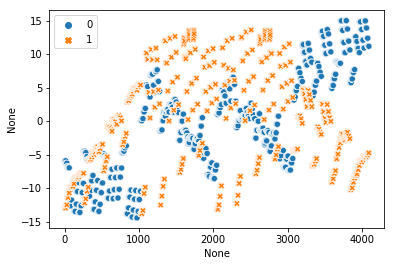

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(q_test)
df_result = pd.DataFrame()
df_result[0] = tsne_results[:,0]
df_result[1] = tsne_results[:,1]

plt.figure()
sns.scatterplot(data=df_result)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3790 samples in 0.003s...
[t-SNE] Computed neighbors for 3790 samples in 0.264s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3790
[t-SNE] Computed conditional probabilities for sample 2000 / 3790
[t-SNE] Computed conditional probabilities for sample 3000 / 3790
[t-SNE] Computed conditional probabilities for sample 3790 / 3790
[t-SNE] Mean sigma: 0.388737
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.387718
[t-SNE] KL divergence after 300 iterations: 1.637660


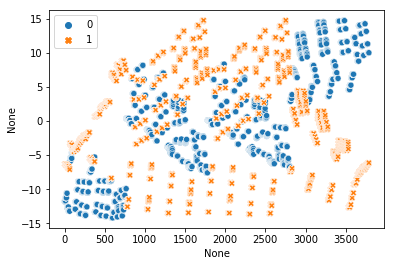

In [72]:
tsne_results = tsne.fit_transform(IOD_q_test)
df_result_1 = pd.DataFrame()
df_result_1[0] = tsne_results[:,0]
df_result_1[1] = tsne_results[:,1]

plt.figure()
sns.scatterplot(data=df_result_1)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 306 samples in 0.001s...
[t-SNE] Computed neighbors for 306 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 306 / 306
[t-SNE] Mean sigma: 0.649576
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.797134
[t-SNE] KL divergence after 300 iterations: 0.355630


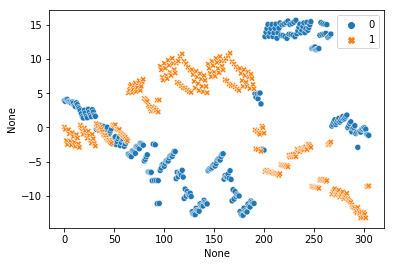

In [73]:
tsne_results = tsne.fit_transform(OOD_q_test)
df_result_2 = pd.DataFrame()
df_result_2[0] = tsne_results[:,0]
df_result_2[1] = tsne_results[:,1]

plt.figure()
sns.scatterplot(data=df_result_2)

In [6]:

def model_builder():
    input_shape = 9
    output_shape = 18
    depth = 6
    width = 64
    reduction_factor = 1.1
    for i in range(depth):
        num_neurons = max(int(width * (reduction_factor ** i)), 4)
        if i == 0:
            inp = Input(shape=(input_shape,))
            x = Dense(num_neurons, activation='relu')(inp)
        else:
            x = Dense(num_neurons, activation='relu')(x)
            
    mean = Dense(output_shape, activation="sigmoid")(x)
    var = Dense(output_shape, activation="softplus")(x)
    
    train_model = Model(inp, mean)
    pred_model = Model(inp, [mean, var])

    train_model.compile(loss=deep_ensemble_regression_nll_loss(var), optimizer="adam", metrics=["mae"])
    return train_model, pred_model

In [7]:


model = model_builder

print(type(model))

<class 'function'>


In [8]:


with tf.device('/cpu:0'):
    ensemble_model = DeepEnsembleRegressor(model_builder, 3)
    ensemble_model.fit(x_train_1, q_train_1, epochs = 100, batch_size = 128, verbose = 1, validation_data=(IOD_x_test, IOD_q_test))

Instructions for updating:
Colocations handled automatically by placer.
Train on 14062 samples, validate on 3790 samples
Epoch 1/100
14062/14062 [==============================] - 1s 39us/sample - loss: -0.6021 - mean_absolute_error: 0.2573 - val_loss: -0.8729 - val_mean_absolute_error: 0.2303
Epoch 2/100
14062/14062 [==============================] - 0s 23us/sample - loss: -1.0131 - mean_absolute_error: 0.2114 - val_loss: -1.1179 - val_mean_absolute_error: 0.1945
Epoch 3/100
14062/14062 [==============================] - 0s 23us/sample - loss: -1.2173 - mean_absolute_error: 0.1770 - val_loss: -1.3371 - val_mean_absolute_error: 0.1614
Epoch 4/100
14062/14062 [==============================] - 0s 23us/sample - loss: -1.2787 - mean_absolute_error: 0.1603 - val_loss: -1.4339 - val_mean_absolute_error: 0.1500
Epoch 5/100
14062/14062 [==============================] - 0s 24us/sample - loss: -1.4874 - mean_absolute_error: 0.1454 - val_loss: -1.5821 - val_mean_absolute_error: 0.1395
Epoch 6/1

Epoch 46/100
14062/14062 [==============================] - 0s 22us/sample - loss: -2.9540 - mean_absolute_error: 0.0345 - val_loss: 19.9075 - val_mean_absolute_error: 0.0387
Epoch 47/100
14062/14062 [==============================] - 0s 22us/sample - loss: -3.0219 - mean_absolute_error: 0.0335 - val_loss: 13.7857 - val_mean_absolute_error: 0.0346
Epoch 48/100
14062/14062 [==============================] - 0s 23us/sample - loss: -3.0390 - mean_absolute_error: 0.0333 - val_loss: 19.7775 - val_mean_absolute_error: 0.0355
Epoch 49/100
14062/14062 [==============================] - 0s 22us/sample - loss: -3.0364 - mean_absolute_error: 0.0330 - val_loss: 19.7267 - val_mean_absolute_error: 0.0354
Epoch 50/100
14062/14062 [==============================] - 0s 21us/sample - loss: -3.0464 - mean_absolute_error: 0.0331 - val_loss: 19.5986 - val_mean_absolute_error: 0.0354
Epoch 51/100
14062/14062 [==============================] - 0s 22us/sample - loss: -2.9921 - mean_absolute_error: 0.0329 - va

Epoch 93/100
14062/14062 [==============================] - 0s 23us/sample - loss: -3.2793 - mean_absolute_error: 0.0275 - val_loss: 30.7550 - val_mean_absolute_error: 0.0330
Epoch 94/100
14062/14062 [==============================] - 0s 23us/sample - loss: -3.2861 - mean_absolute_error: 0.0271 - val_loss: 34.7638 - val_mean_absolute_error: 0.0332
Epoch 95/100
14062/14062 [==============================] - 0s 22us/sample - loss: -3.2796 - mean_absolute_error: 0.0273 - val_loss: 33.9926 - val_mean_absolute_error: 0.0327
Epoch 96/100
14062/14062 [==============================] - 0s 23us/sample - loss: -3.2550 - mean_absolute_error: 0.0275 - val_loss: 34.5250 - val_mean_absolute_error: 0.0324
Epoch 97/100
14062/14062 [==============================] - 0s 23us/sample - loss: -3.2855 - mean_absolute_error: 0.0270 - val_loss: 27.8325 - val_mean_absolute_error: 0.0331
Epoch 98/100
14062/14062 [==============================] - 0s 23us/sample - loss: -3.2869 - mean_absolute_error: 0.0270 - va

Epoch 86/100
14062/14062 [==============================] - 0s 23us/sample - loss: -3.1776 - mean_absolute_error: 0.0305 - val_loss: 34.4714 - val_mean_absolute_error: 0.0366
Epoch 87/100
14062/14062 [==============================] - 0s 23us/sample - loss: -3.1538 - mean_absolute_error: 0.0306 - val_loss: 22.6828 - val_mean_absolute_error: 0.0370
Epoch 88/100
14062/14062 [==============================] - 0s 24us/sample - loss: -3.1292 - mean_absolute_error: 0.0308 - val_loss: 35.4087 - val_mean_absolute_error: 0.0346
Epoch 89/100
14062/14062 [==============================] - 0s 23us/sample - loss: -3.1895 - mean_absolute_error: 0.0302 - val_loss: 34.2371 - val_mean_absolute_error: 0.0378
Epoch 90/100
14062/14062 [==============================] - 0s 25us/sample - loss: -3.2038 - mean_absolute_error: 0.0297 - val_loss: 33.1285 - val_mean_absolute_error: 0.0351
Epoch 91/100
14062/14062 [==============================] - 0s 24us/sample - loss: -2.9959 - mean_absolute_error: 0.0321 - va

Epoch 79/100
14062/14062 [==============================] - 0s 23us/sample - loss: -2.8396 - mean_absolute_error: 0.0444 - val_loss: 51.4570 - val_mean_absolute_error: 0.0515
Epoch 80/100
14062/14062 [==============================] - 0s 23us/sample - loss: -2.8772 - mean_absolute_error: 0.0429 - val_loss: 50.9767 - val_mean_absolute_error: 0.0498
Epoch 81/100
14062/14062 [==============================] - 0s 23us/sample - loss: -2.8540 - mean_absolute_error: 0.0413 - val_loss: 53.1445 - val_mean_absolute_error: 0.0518
Epoch 82/100
14062/14062 [==============================] - 0s 23us/sample - loss: -2.8831 - mean_absolute_error: 0.0409 - val_loss: 46.7502 - val_mean_absolute_error: 0.0478
Epoch 83/100
14062/14062 [==============================] - 0s 23us/sample - loss: -2.9043 - mean_absolute_error: 0.0399 - val_loss: 51.0764 - val_mean_absolute_error: 0.0462
Epoch 84/100
14062/14062 [==============================] - 0s 23us/sample - loss: -2.9155 - mean_absolute_error: 0.0393 - va

In [9]:
mean_test, sd_test = ensemble_model.predict(x_test)
mean_test = q_scaler.inverse_transform(mean_test)
q_test_unorm = q_scaler.inverse_transform(q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test, sd_test**2)))

NLL: 14.36622


In [15]:
mean_test_IOD, sd_test_IOD = ensemble_model.predict(IOD_x_test)
mean_test_IOD = q_scaler.inverse_transform(mean_test_IOD)
#sd_test_IOD = q_scaler.inverse_transform(sd_test_IOD)
q_test_unorm = q_scaler.inverse_transform(IOD_q_test)
global_mae = mean_absolute_error(q_test_unorm, mean_test_IOD)
print(global_mae)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_IOD, sd_test_IOD**2)))

0.018715716568243654
NLL: 15.31887


In [16]:
mean_test_OOD, sd_test_OOD = ensemble_model.predict(OOD_x_test)
mean_test_OOD = q_scaler.inverse_transform(mean_test_OOD)
#sd_test_OOD = q_scaler.inverse_transform(sd_test_OOD)
q_test_unorm = q_scaler.inverse_transform(OOD_q_test)
global_mae = mean_absolute_error(q_test_unorm, mean_test_OOD)
print(global_mae)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_OOD, sd_test_OOD**2)))

0.03250184117357827
NLL: 2.56705


In [28]:
col_no = 1

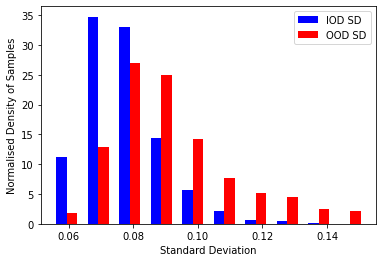

In [29]:
sd_test_IOD_df = pd.DataFrame(sd_test_IOD)
sd_test_OOD_df = pd.DataFrame(sd_test_OOD)
new_scores = np.concatenate([sd_test_IOD_df[col_no], sd_test_OOD_df[col_no]], axis=0)
minmaxscaler = MinMaxScaler()
new_scores_scaled = minmaxscaler.fit_transform(new_scores.reshape(-1, 1))
new_labels = np.concatenate([np.zeros_like(sd_test_IOD_df[col_no]), np.ones_like(sd_test_OOD_df[col_no])], axis=0)
histogram_df = pd.DataFrame(new_scores_scaled, new_labels)

#histogram_df.hist(column=0)

#sd_test_IOD_df.hist(column=0)
#sd_test_OOD_df.hist(column=0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(sd_test_IOD_df[col_no].values.reshape(-1, 1), density=True)
b_heights, b_bins = np.histogram(sd_test_OOD_df[col_no].values.reshape(-1, 1), bins=a_bins, density=True)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width = width, facecolor='blue',label="IOD SD")
ax.bar(b_bins[:-1]+width, b_heights, width = width, facecolor='red', label="OOD SD")
ax.legend()
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Normalised Density of Samples")
fig.savefig("density_vs_sd_ensemble_iso_split_col_1.pdf")

0.7585221687619638


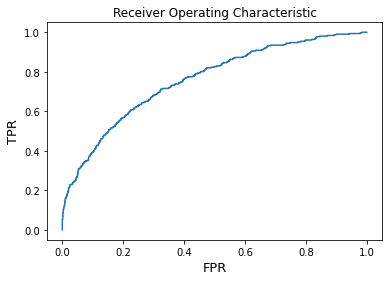

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
norm_scores = new_scores - min(new_scores) / (max(new_scores) - min(new_scores))

auc = roc_auc_score(new_labels, new_scores)
fpr, tpr, threshs = roc_curve(new_labels, norm_scores, drop_intermediate=True)
print(auc)
plt.xlabel('FPR', fontsize=13)
plt.ylabel('TPR', fontsize=13)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.savefig("auc_ensemble_iso_split_col_1.pdf")
plt.show()


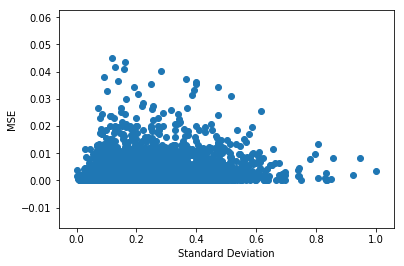

In [44]:
from sklearn.metrics import mean_squared_error

mean_test, sd_test = ensemble_model.predict(x_test)
mean_test = q_scaler.inverse_transform(mean_test)
#sd_test_IOD = q_scaler.inverse_transform(sd_test_IOD)
q_unorm = q_scaler.inverse_transform(q_test)

mean_test_df = pd.DataFrame(mean_test)
sd_test_df = pd.DataFrame(sd_test)
q_df = pd.DataFrame(q_test)

MEAN = np.array(mean_test_df[0])
SD = np.array(sd_test_df[0])
Q = np.array(q_df[0])
Q = Q.reshape(-1, 1)


mean_scaler = MinMaxScaler()
MEAN = mean_scaler.fit_transform(MEAN.reshape(-1, 1))
sd_scaler = MinMaxScaler()
SD = sd_scaler.fit_transform(SD.reshape(-1, 1))

MSE = np.square(np.subtract(Q, MEAN))
plt.figure()

plt.scatter(SD, MSE)
plt.xlabel('Standard Deviation')
plt.ylabel('MSE')
#plt.savefig("./Art.pdf")
plt.show()